# **IMPORT MODULES/FUNCTIONS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from efficient_kan.src.efficient_kan import KAN
#from kan import *
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import get_mean_pulse_from_set, momentos, gauss, gauss_fit, move_to_reference, create_and_delay_pulse_pair, create_position, set_seed, calculate_gaussian_center_sigma, normalize, normalize_given_params
from functions_KAN import n_params_KAN, train_loop_KAN

In [3]:
V55 = np.load('/home/josea/Co60_5cm_5cm.npy')
V28 = np.load('/home/josea/Co60_2cm_8cm.npy')
V82 = np.load('/home/josea/Co60_8cm_2cm.npy')

#V28 = np.load('/home/josea/TFM_Alba_Co60_2cm_8cm_fullgate_polyfit.npz')['data']
#V55 = np.load('/home/josea/TFM_Alba_Co60_5cm_5cm_fullgate_polyfit.npz')['data']
#V82 = np.load('/home/josea/TFM_Alba_Co60_8cm_2cm_fullgate_polyfit.npz')['data']
REALS = np.concatenate((V28, V55, V82), axis = 0)


data = np.load('/home/josea/pulsos_Co60_filt_norm_5k_polyfit.npz')['data']
#data = np.load('/home/josea/PRUEBA_Co60.npz')['data']



data = np.load('/home/josea/pulsos_Na22_filt_norm_practica_polyfit.npz')['data']

# **INTERPOLATION**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
EXTRASAMPLING = 8
Nt = np.shape(data)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_REALS = interp1d(tiempo, REALS, kind = 'cubic', axis = 1)
new_REALS = interp_func_REALS(tiempo_new)

interp_func_data = interp1d(tiempo, data, kind = 'cubic', axis = 1)
new_data = interp_func_data(tiempo_new)


#--------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_data[:,:,1] = np.roll(new_data[:,:,1], align_steps)
new_data[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


# **GENERATE MEAN PULSE PER DETECTOR**

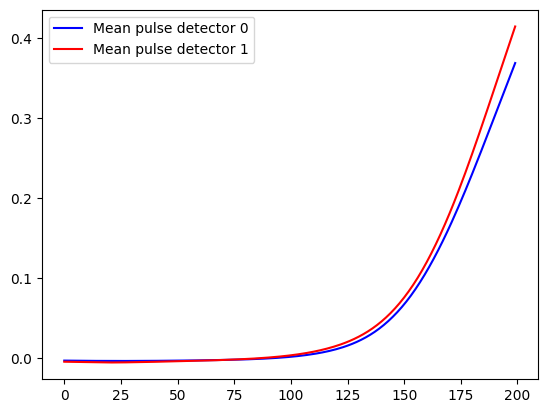

In [5]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_data, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_data, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
start = 50*EXTRASAMPLING 
stop = 75*EXTRASAMPLING

plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

# **DETECTORS**

In [6]:
#---------------------------------- Important definitions ------------------------------------
ajuste_grueso = 1  # 0 = YES, 1 = NO
delay_steps = 30  # Max number of steps to delay pulses
moments_order = 5  # Max order of moments used
set_seed(42) #Fix seeds
nbins = 51 #Num bins for all histograms
create_positions = 0 # Wether to create new_source positions. (0 = YES, 1 = NO)                           
t_shift = 8 #Time steps to move for the new positions
normalization_method = 'min-max'

# Train/test set split
train_data = new_data[:18000,:,:] # choose data to be used for training 
test_data = new_data[18000:,:,:]
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  18000
Número de casos de test:  4743


In [7]:
# Create train set 
if ajuste_grueso == 0:

    # Move pulses to align with mean and then delay them 
    delays2_dec0, moved_pulses2_dec0 = move_to_reference(mean_pulse_dec0, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays2_dec1, moved_pulses2_dec1 = move_to_reference(mean_pulse_dec1, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    
    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(moved_pulses2_dec0, new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(moved_pulses2_dec1, new_time_step, delay_steps = delay_steps, NOISE = False)


if ajuste_grueso == 1:

    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = False)

Text(0.5, 1.0, 'Detector 1')

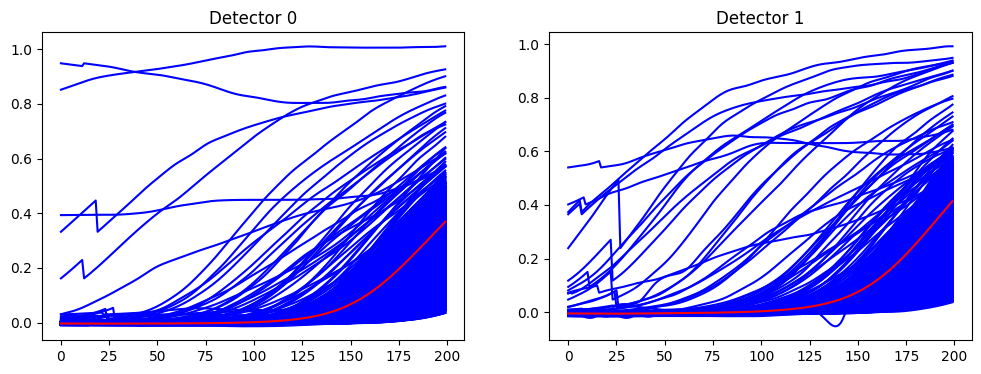

In [8]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.plot(mean_pulse_dec0[start:stop],'r-')
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
    plt.plot(trainX_dec1[i,:,0],'b-')
plt.plot(mean_pulse_dec1[start:stop],'r-')
plt.title('Detector 1')

In [9]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order) 
M_Train_dec1 = momentos(trainX_dec1, order = moments_order) 

#-------------------------------------------------------------- Normalize ---------------------------------------------------
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = normalization_method)
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = normalization_method)

#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Normalization parameters detector 0:", params_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Normalization parameters detector 1:", params_dec1)

(18000, 5, 2) NM = 5
Normalization parameters detector 0: (array([-0.17009462,  0.21375523,  0.31783874,  0.35064573,  0.35782339]), array([193.33900544,  99.18151646,  66.86345177,  50.45088672,
        40.5257902 ]))
(18000, 5, 2) NM = 5
Normalization parameters detector 1: (array([-0.16910778,  0.28950472,  0.36777678,  0.38812232,  0.38800863]), array([157.46394747,  89.2646765 ,  62.24002327,  47.7132532 ,
        38.67770044]))


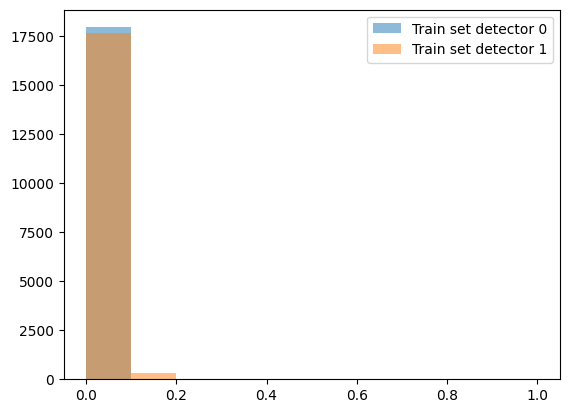

In [10]:
plt.hist(M_Train_dec0[:,0,0], alpha = 0.5, label = 'Train set detector 0');
plt.hist(M_Train_dec1[:,0,0], alpha = 0.5, label = 'Train set detector 1');

plt.legend()

# **FULL TOF (KAN)**

In [11]:
#-------------------------------- Create test set ---------------------------------------------------------
if ajuste_grueso == 0:
    delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, test_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, test_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    
    if create_positions == 1:
        TEST = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)

    if create_positions == 0:
        TEST_00 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
        TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
        TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
        TEST = np.concatenate((TEST_02, TEST_00, TEST_20), axis = 0)

if ajuste_grueso == 1:
    
    if create_positions == 1:
        TEST = test_data[:,start:stop,:]
    
    if create_positions == 0:
        TEST_00 = test_data[:,start:stop,:] 
        TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
        TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
        TEST = np.concatenate((TEST_02, TEST_00, TEST_20), axis = 0)



MOMENTS_TEST = momentos(TEST, order = moments_order)
MOMENTS_TEST_norm_dec0 = normalize_given_params(MOMENTS_TEST, params_dec0, channel = 0, method = normalization_method)
MOMENTS_TEST_norm_dec1 = normalize_given_params(MOMENTS_TEST, params_dec1, channel = 1, method = normalization_method)
MOMENTS_TEST = np.stack((MOMENTS_TEST_norm_dec0, MOMENTS_TEST_norm_dec1), axis = -1)

In [12]:
# Define model parameters
architecture = [NM, NM*2, 1, 1]  
grid_size = 5   #Efficient KAN uses grid size 5
k_order = 3

# Initialize model
#model_dec0 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)
#model_dec1 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)

model_dec0 = KAN(architecture)
model_dec1 = KAN(architecture)
n_params = n_params_KAN(architecture, grid_size, k_order)
print('Number of parameters for this architecture:', n_params) #Se calcula el número de parametros igual en efficient kan?

Number of parameters for this architecture: 488


In [13]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = 5e-4) #Regularization?
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = 5e-4)  

In [14]:
# Execute train loop
loss_dec0, test_dec0 = train_loop_KAN(model_dec0, optimizer_dec0, train_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]).float(), EPOCHS = 200, save = False) 
loss_dec1, test_dec1 = train_loop_KAN(model_dec1, optimizer_dec1, train_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]).float(), EPOCHS = 200, save = False)

EPOCH 1:
LOSS train 0.09344275628491652
EPOCH 2:
LOSS train 0.08550642965878509
EPOCH 3:
LOSS train 0.005488515777102824
EPOCH 4:
LOSS train 0.0011371242966742364
EPOCH 5:
LOSS train 0.0008336540151918158
EPOCH 6:
LOSS train 0.0007011167968987293
EPOCH 7:
LOSS train 0.000599769411040586
EPOCH 8:
LOSS train 0.0005592248297591232
EPOCH 9:
LOSS train 0.0005018211912140673
EPOCH 10:
LOSS train 0.0004720795059580152
EPOCH 11:
LOSS train 0.00045491461765596533
EPOCH 12:
LOSS train 0.00041994630877285687
EPOCH 13:
LOSS train 0.0004145775171675391
EPOCH 14:
LOSS train 0.0003916185692024585
EPOCH 15:
LOSS train 0.0003805183951368119
EPOCH 16:
LOSS train 0.00037340213535422934
EPOCH 17:
LOSS train 0.0003679037764022173
EPOCH 18:
LOSS train 0.0003639331978813702
EPOCH 19:
LOSS train 0.0003583133902372871
EPOCH 20:
LOSS train 0.0003516511370173015
EPOCH 21:
LOSS train 0.00034588877368481
EPOCH 22:
LOSS train 0.0003393030162581476
EPOCH 23:
LOSS train 0.0003557238585706734
EPOCH 24:
LOSS train 0.00

/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:40: RuntimeWarning: divide by zero encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:40: RuntimeWarning: invalid value encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:42: RuntimeWarning: invalid value encountered in scalar divide
  mean = sum(x * y) / sum(y)


121 0.09118785976470609
V55 MAE: 0.09081652777264564
V28 MAE: 0.09188938047584436
V82 MAE: 0.09085767104562822


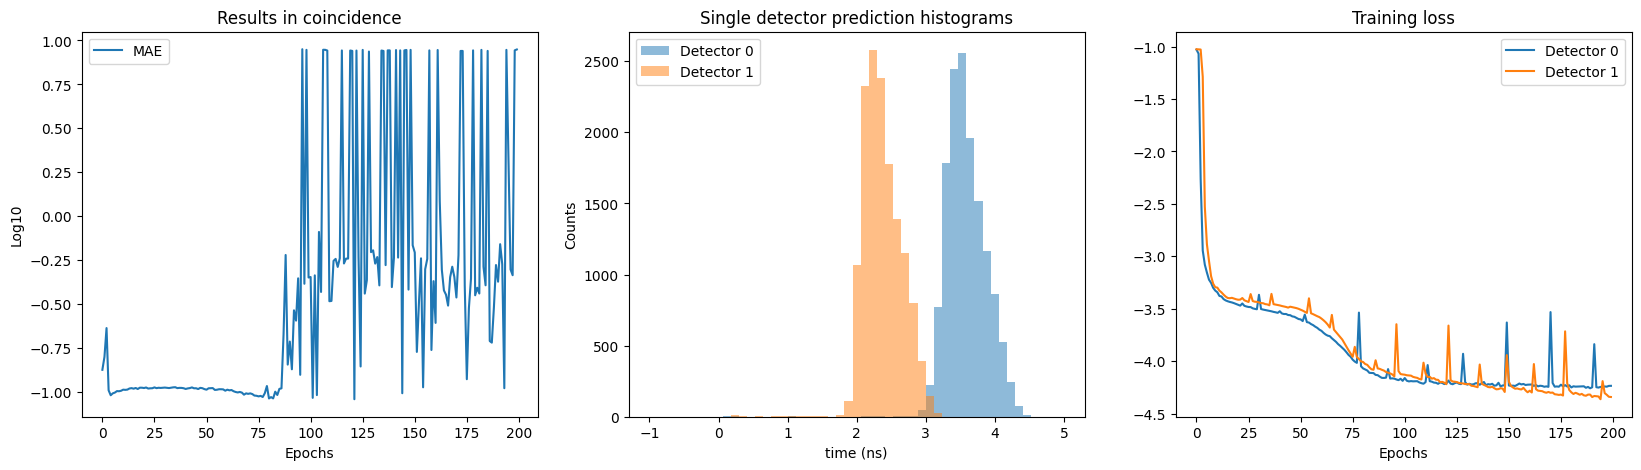

In [15]:
if ajuste_grueso == 0:

    if create_positions == 1:
        TOFN = (test_dec0 - new_time_step*delays_test_dec0) - (test_dec1 - new_time_step*delays_test_dec1)
        TOFN_V28 = TOFN[:,:V28.shape[0]] - test_dec1[:,: V28.shape[0]]
        TOFN_V55 = TOFN[:,V28.shape[0] : V28.shape[0] + V55.shape[0]]  - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] 
        TOFN_V82 = TOFN[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:] 
    
    if create_positions == 0:
        TOFN_V28 = (test_dec0[:,:TEST_00.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,:TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V55 = (test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V82 = (test_dec0[:,2*TEST_00.shape[0]:]  - new_time_step*delays_test_dec0) - (test_dec1[:,2*TEST_00.shape[0]:] - new_time_step*delays_test_dec1)
    
if ajuste_grueso == 1:
    
    if create_positions == 1:
        TOFN_V28 = test_dec0[:,:V28.shape[0]] - test_dec1[:,:V28.shape[0]]
        TOFN_V55 = test_dec0[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]]
        TOFN_V82 = test_dec0[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:]

    if create_positions == 0:
        TOFN_V28 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
        TOFN_V55 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
        TOFN_V82 = test_dec0[:,2*TEST_00.shape[0]:] - test_dec1[:,2*TEST_00.shape[0]:]
    
    
# Must turn to float64 in order to calculate std on a specific axis
TOFN_V28 = np.array(TOFN_V28, dtype = 'float64') 
TOFN_V55 = np.array(TOFN_V55, dtype = 'float64')
TOFN_V82 = np.array(TOFN_V82, dtype = 'float64') 

# Calculate 'centroids'
centroid_V55, sigmaN_V55 = calculate_gaussian_center_sigma(TOFN_V55, np.zeros((TOFN_V55.shape[0])), nbins = nbins)  
centroid_V28, sigmaN_V28 = calculate_gaussian_center_sigma(TOFN_V28, centroid_V55, nbins = nbins)
centroid_V82, sigmaN_V82 = calculate_gaussian_center_sigma(TOFN_V82, centroid_V55, nbins = nbins)

# Get errors to calculate Epsilon
error_V28 = abs((TOFN_V28 - centroid_V55[:, np.newaxis] + 0.2))
error_V55 = abs((TOFN_V55 - centroid_V55[:, np.newaxis]))
error_V82 = abs((TOFN_V82 - centroid_V55[:, np.newaxis] - 0.2))


Error = np.concatenate((error_V28, error_V55, error_V82), axis = 1)
MAE = np.mean(Error, axis = 1)
idx_min_MAE = np.where(MAE == np.min(MAE))[0][0]
print(idx_min_MAE, np.min(MAE))
print('V55 MAE:', np.mean(error_V55[idx_min_MAE,:]))
print('V28 MAE:', np.mean(error_V28[idx_min_MAE,:]))
print('V82 MAE:', np.mean(error_V82[idx_min_MAE,:]))

# PLot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE[:]), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
if ajuste_grueso == 0:
    plt.hist(test_dec0[idx_min_MAE , :delays_test_dec0.shape[0]] - new_time_step*delays_test_dec0, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :delays_test_dec1.shape[0]] - new_time_step*delays_test_dec1, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 1');

if ajuste_grueso == 1:
    plt.hist(test_dec0[idx_min_MAE , :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0[:].astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1[:].astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()


V82: CENTROID(ns) = 0.196  FWHM(ns) = 0.235  std(ns) = 0.100
V55: CENTROID(ns) = -0.002  FWHM(ns) = 0.232  std(ns) = 0.098
V28: CENTROID(ns) = -0.203  FWHM(ns) = 0.233  std(ns) = 0.099


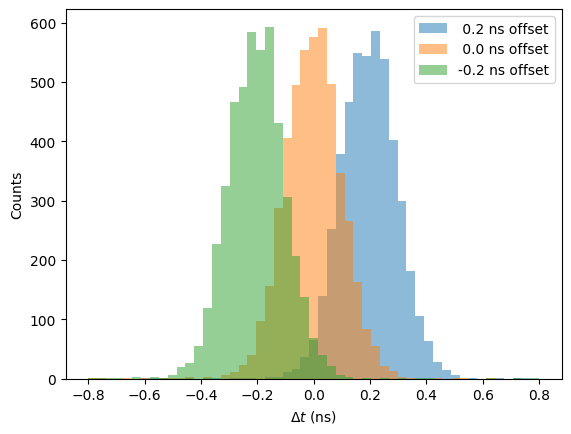

In [16]:
epoch = idx_min_MAE
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82[epoch,:] - centroid_V55[epoch], bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = ' 0.2 ns offset');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55[epoch,:] - centroid_V55[epoch], bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = ' 0.0 ns offset');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28[epoch,:] - centroid_V55[epoch], bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = '-0.2 ns offset');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')

FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

In [17]:
import time

time_test = np.tile(trainX_dec0[0,:,:], (1000000, 1,1))

# Start timer moments
start_time_momentos = time.time()
M_time_test = momentos(time_test, order = moments_order)
end_time_momentos = time.time()


# Start timer inference
start_time_inference= time.time()
with torch.no_grad():
    assert not torch.is_grad_enabled()
    output_time_test = model_dec0(torch.tensor(M_time_test[:,:,0]).float())
end_time_inference = time.time()

# Calculate the elapsed times
elapsed_time_momentos = end_time_momentos - start_time_momentos
elapsed_time_inference = end_time_inference - start_time_inference

print(f"Elapsed time momentos: {elapsed_time_momentos} seconds")
print(f"Elapsed time inference: {elapsed_time_inference} seconds")

Elapsed time momentos: 13.595553398132324 seconds
Elapsed time inference: 0.9250526428222656 seconds


Text(0, 0.5, 'Absolute error')

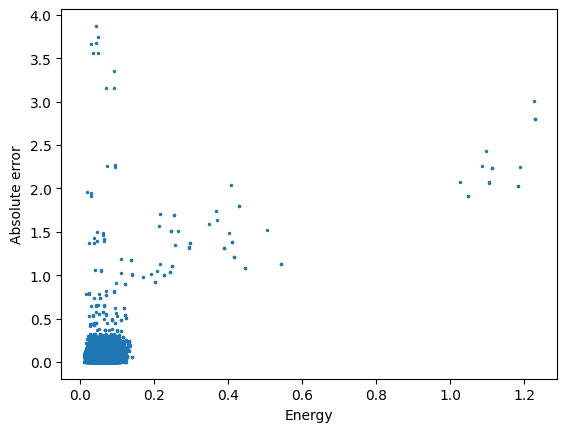

In [18]:
energy = MOMENTS_TEST[:,0,:]

plt.plot(energy[:,1], Error[epoch,:], 'o', markersize = 1.5)
plt.xlabel('Energy')
plt.ylabel('Absolute error')